<a href="https://colab.research.google.com/github/leoclementliao/DashIntro/blob/master/yolov3_s2_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!/opt/bin/nvidia-smi

Tue Apr 14 11:47:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
## git yolo3_tf2 and pip libraries
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt

## Copy tfrecord dataset
% cp -r /content/drive/My\ Drive/Colab\ Notebooks/YoloV3/data /content/yolov3-tf2/data

## Download yolov3 weight (12 minutes)
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 341, done.
remote: Total 341 (delta 0), reused 0 (delta 0), pack-reused 341
Receiving objects: 100% (341/341), 4.16 MiB | 2.81 MiB/s, done.
Resolving deltas: 100% (198/198), done.
/content/yolov3-tf2
Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 421.8MB 17kB/s 
     |████████████████████████████████| 28.7MB 108kB/s 
     |████████████████████████████████| 450kB 39.2MB/s 
     |████████████████████████████████| 3.9MB 36.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=bd18610731785bbfc17597f7414d6ee5724b5a6d4a84a0d782688baa50b11788
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorboard<2.3

In [6]:
## Training parameters
epochs = 3
batch_size = 8
learning_rate = 1e-3
image_size = 416
weights_dir = '/content/yolov3-tf2/data/yolov3.weights'
checkpoint_dir = '/content/yolov3-tf2/checkpoints/yolov3.tf'

## Dataset directory
train_dir = '/content/yolov3-tf2/data/data/voc2009_train.tfrecord'
val_dir = '/content/yolov3-tf2/data/data/voc2009_val.tfrecord'
classes_dir = "/content/yolov3-tf2/data/data/voc2009.name"

## Load class names
class_names = []
with open(classes_dir, "r") as f:
    for s in f:
        class_names.append(s[:-1])

num_classes = len(class_names)
print(f'{num_classes} classes')


20 classes


In [2]:
! ls /content/yolov3-tf2/checkpoints

checkpoint		       yolov3_train.tf.data-00000-of-00002
yolov3.tf.data-00000-of-00002  yolov3_train.tf.data-00001-of-00002
yolov3.tf.data-00001-of-00002  yolov3_train.tf.index
yolov3.tf.index


In [25]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
import yolov3_tf2.dataset as dataset
from yolov3_tf2.utils import draw_outputs, load_darknet_weights, freeze_all
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny, YoloLoss,
    yolo_anchors, yolo_anchor_masks,
    yolo_tiny_anchors, yolo_tiny_anchor_masks
)
from yolov3_tf2.utils import freeze_all
from google.colab.patches import cv2_imshow

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

DuplicateFlagError: ignored

In [0]:
anchors = yolo_anchors
anchor_masks = yolo_anchor_masks

In [27]:
train_dataset = load_tfrecord_dataset(train_dir, classes_dir, size=image_size)
train_dataset = train_dataset.shuffle(buffer_size=512)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(lambda x, y: (
    dataset.transform_images(x, image_size),
    dataset.transform_targets(y, anchors, anchor_masks, image_size)))
train_dataset = train_dataset.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.repeat()


val_dataset = load_tfrecord_dataset(val_dir, classes_dir, size=image_size)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.map(lambda x, y: (
    dataset.transform_images(x, image_size),
    dataset.transform_targets(y, anchors, anchor_masks, image_size)))

train_dataset

<RepeatDataset shapes: ((None, 416, 416, 3), ((None, 13, 13, 3, 6), (None, 26, 26, 3, 6), (None, 52, 52, 3, 6))), types: (tf.float32, (tf.float32, tf.float32, tf.float32))>

In [0]:
## Load model
# !python convert.py


In [0]:
## Load model and save checkpoint files (convert pretrain model weight)
model_pretrained = YoloV3(classes=80) # The pretrain model is on coco dataset
load_darknet_weights(model_pretrained, weights_dir, tiny=False)
model_pretrained.save_weights(checkpoint_dir)

In [0]:
## Load darknet weight in the model
model = YoloV3(size=image_size, classes=num_classes, training=True,)
model.get_layer('yolo_darknet').set_weights(
                model_pretrained.get_layer('yolo_darknet').get_weights())
freeze_all(model.get_layer('yolo_darknet'))



In [0]:
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
loss = [YoloLoss(anchors[mask], classes=num_classes) for mask in anchor_masks]

model.compile(optimizer=optimizer, loss=loss)

callbacks = [
    ReduceLROnPlateau(verbose=1),
    # EarlyStopping(patience=3, verbose=1),
    ModelCheckpoint('/content/yolov3-tf2/checkpoints/yolov3_train_{epoch}.tf',
                    verbose=1, save_weights_only=True),
    # TensorBoard(log_dir='logs')
]


In [0]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    steps_per_epoch= 3480// batch_size,
                    validation_steps = 448//batch_size,
                    epochs=30,
                    callbacks=callbacks,
                    )
trained_checkpoint_dir = '/content/yolov3-tf2/checkpoints/yolov3_train.tf'
model.save_weights(trained_checkpoint_dir)

Train for 435 steps, validate for 56 steps
Epoch 1/30
434/435 [============================>.] - ETA: 0s - loss: 19.0844 - yolo_output_0_loss: 2.3462 - yolo_output_1_loss: 2.3058 - yolo_output_2_loss: 2.3831
Epoch 00001: saving model to /content/yolov3-tf2/checkpoints/yolov3_train_1.tf
435/435 [==============================] - 150s 344ms/step - loss: 19.0699 - yolo_output_0_loss: 2.3418 - yolo_output_1_loss: 2.3005 - yolo_output_2_loss: 2.3777 - val_loss: 25.5646 - val_yolo_output_0_loss: 5.9826 - val_yolo_output_1_loss: 5.5951 - val_yolo_output_2_loss: 1.7095
Epoch 2/30
434/435 [============================>.] - ETA: 0s - loss: 17.4872 - yolo_output_0_loss: 1.8006 - yolo_output_1_loss: 1.7063 - yolo_output_2_loss: 1.6923
Epoch 00002: saving model to /content/yolov3-tf2/checkpoints/yolov3_train_2.tf
435/435 [==============================] - 133s 306ms/step - loss: 17.4756 - yolo_output_0_loss: 1.7968 - yolo_output_1_loss: 1.7024 - yolo_output_2_loss: 1.6884 - val_loss: 27.6327 - val_

In [45]:
yolo = YoloV3(classes=num_classes)
yolo.load_weights(trained_checkpoint_dir).expect_partial()
# yolo.load_weights('/content/yolov3-tf2/checkpoints/yolov3_train_3.tf').expect_partial()


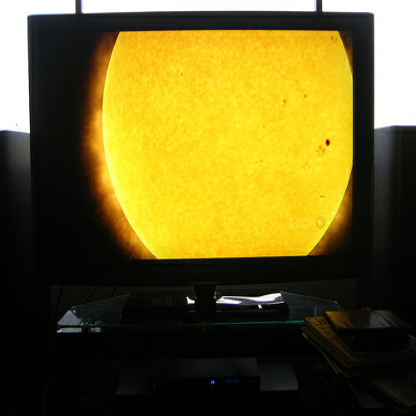

In [46]:
# from google.colab.patches import cv2_imshow
dataset = load_tfrecord_dataset(val_dir, classes_dir, size=image_size)
for image, labels in dataset.take(1):
    boxes = []
    scores = []
    classes = []
    # for x1, y1, x2, y2, label in labels:
    #     if x1 == 0 and x2 == 0:
    #         continue

    #     boxes.append((x1, y1, x2, y2))
    #     scores.append(1)
    #     classes.append(label)
    # nums = [len(boxes)]
    # boxes = [boxes]
    # scores = [scores]
    # classes = [classes]
    img = tf.expand_dims(image, 0)
    img = transform_images(img, FLAGS.size)
    boxes, scores, classes, nums = yolo(img)

    img = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

cv2_imshow(img)

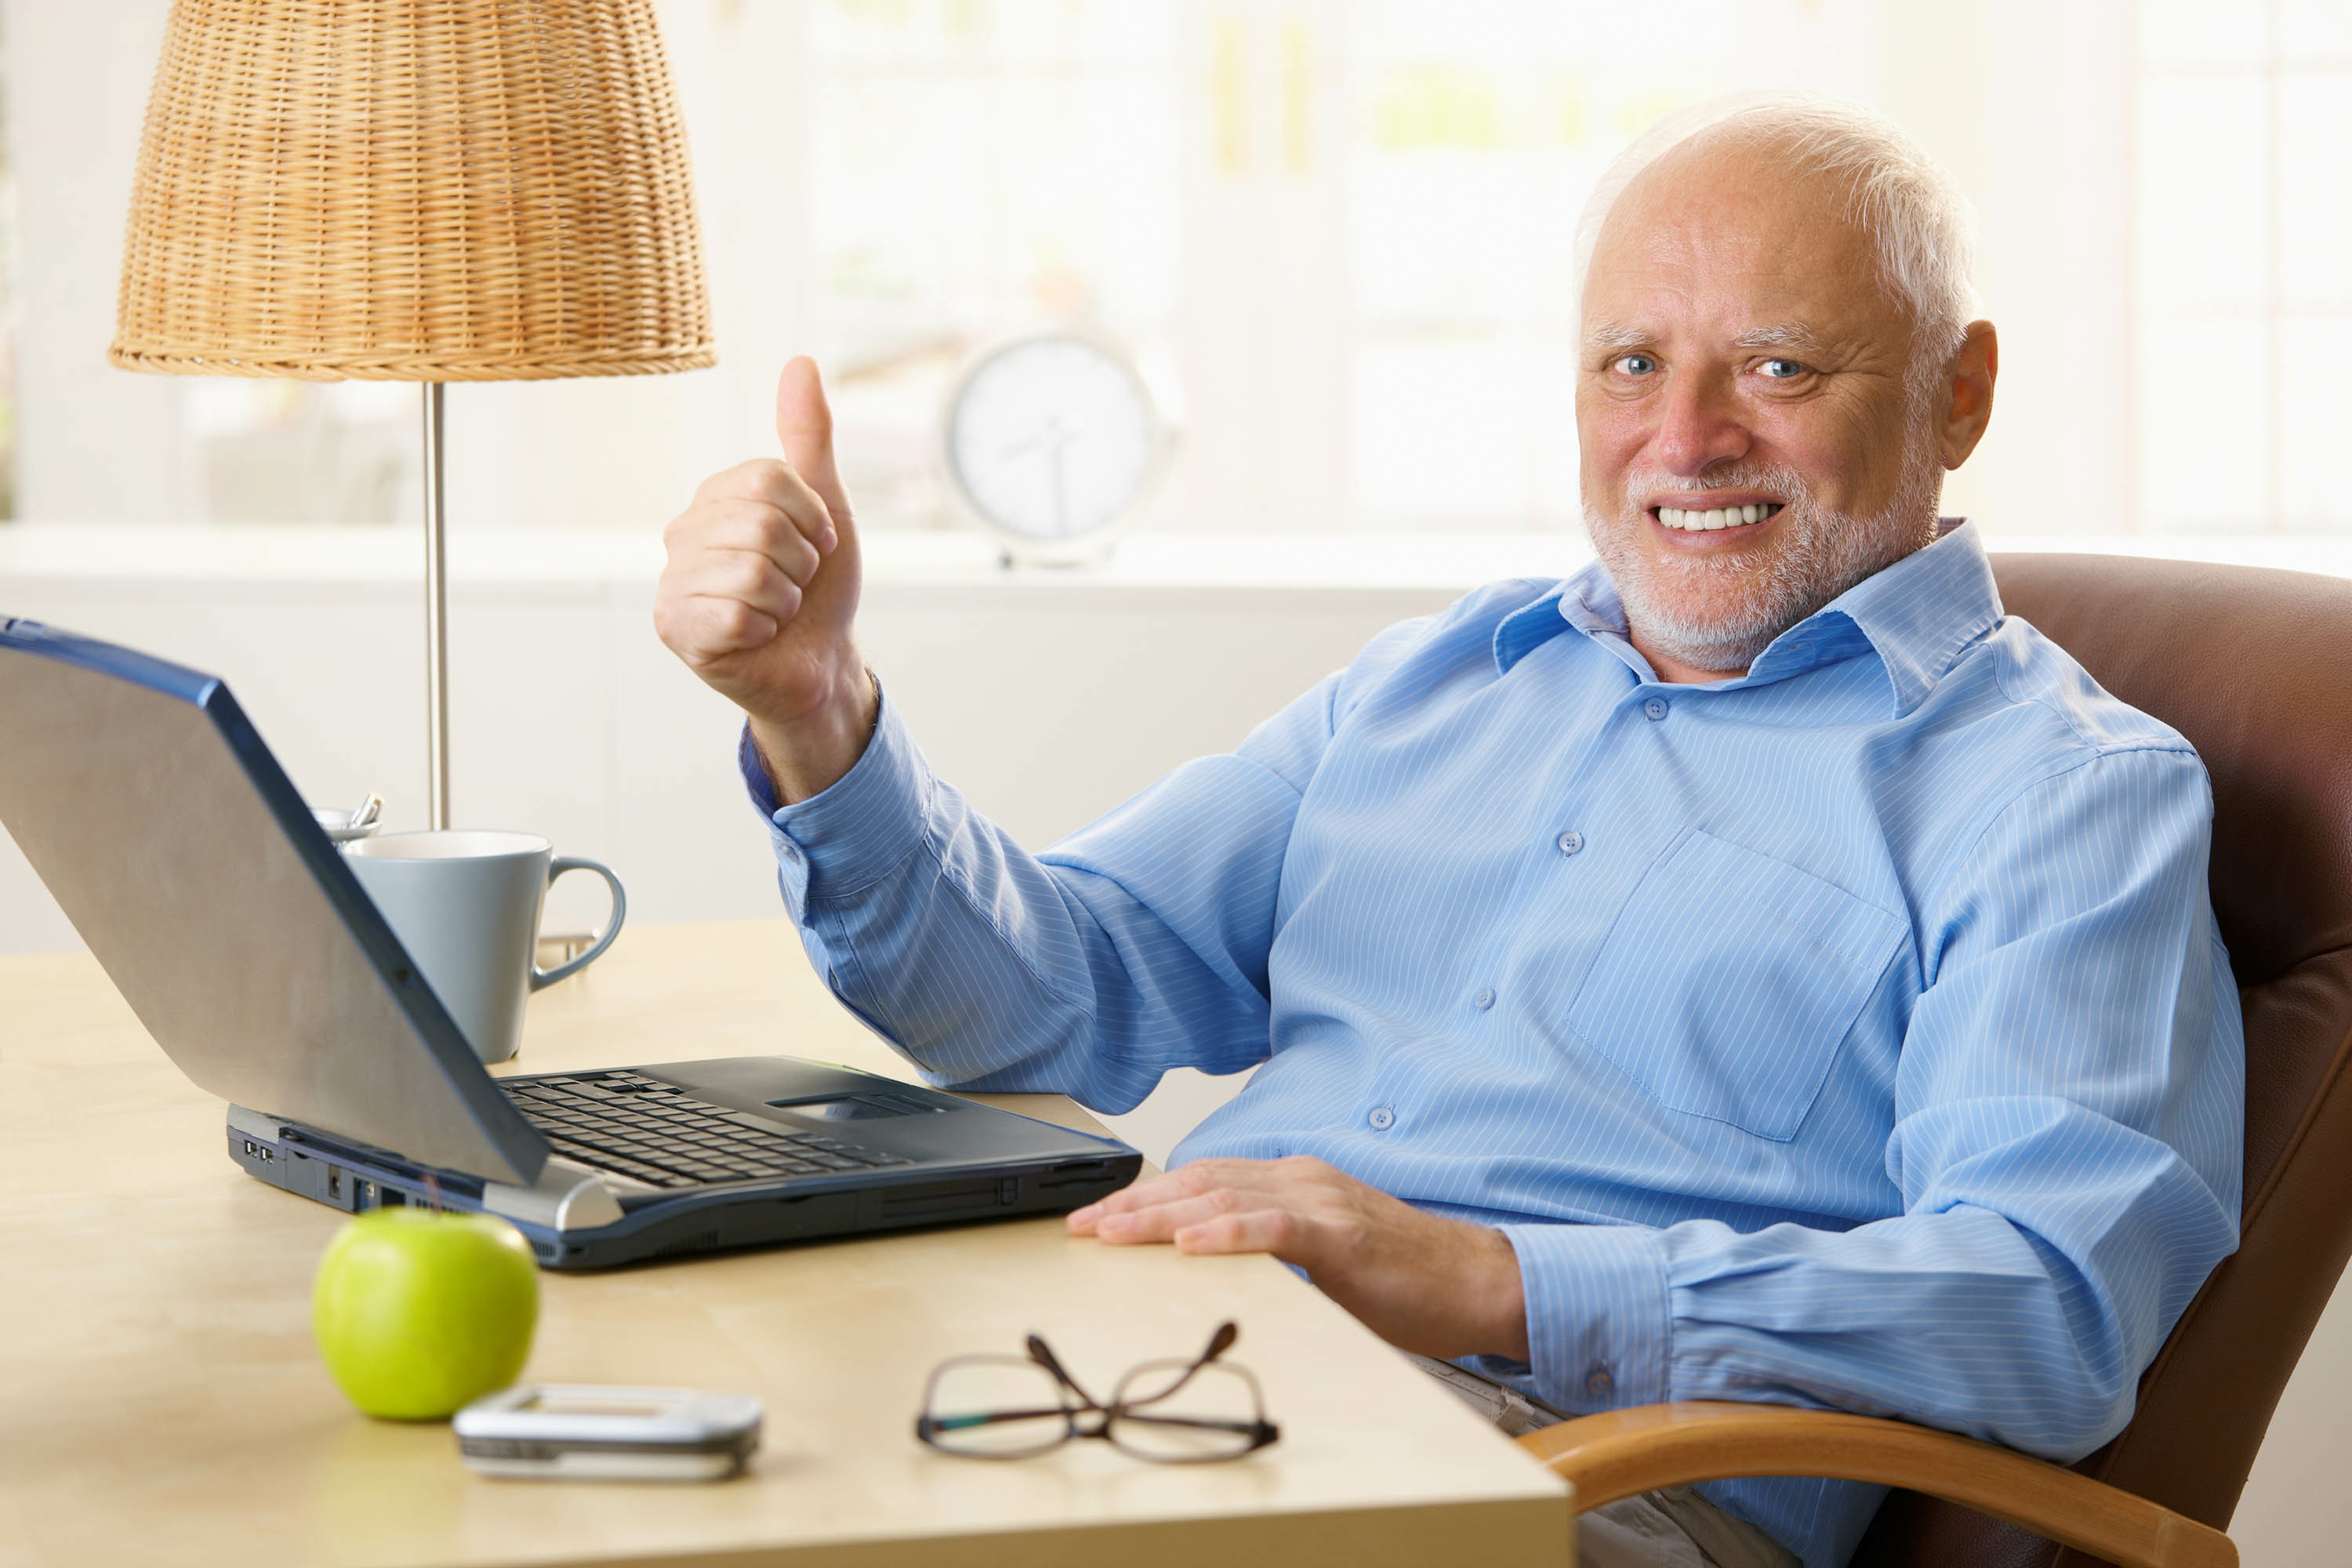

In [47]:
FLAGS.image = '/content/yolov3-tf2/data/meme.jpg'

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

boxes, scores, classes, nums = yolo(img)

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

cv2_imshow(img)

In [40]:
boxes

<tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0.

In [0]:
dataset = load_tfrecord_dataset(val_dir, classes_dir, size=image_size)
for image, labels in dataset.take(1):
    boxes = []
    scores = []
    classes = []
    for x1, y1, x2, y2, label in labels:
        if x1 == 0 and x2 == 0:
            continue

        boxes.append((x1, y1, x2, y2))
        scores.append(1)
        classes.append(label)
    nums = [len(boxes)]
    boxes = [boxes]
    scores = [scores]
    classes = [classes]

    img = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

cv2_imshow(img)




In [36]:
labels[0].shape

TensorShape([8, 13, 13, 3, 6])

In [0]:
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]

YOLOV3_TINY_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
]

def load_darknet_weights(model, weights_file, tiny=False):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    if tiny:
        layers = YOLOV3_TINY_LAYER_LIST
    else:
        layers = YOLOV3_LAYER_LIST

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            logging.info("{}/{} {}".format(
                sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    # assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()

In [1]:
yolo = YoloV3(classes=num_classes)
load_darknet_weights(yolo, weights_dir, tiny=False)


NameError: ignored

In [44]:
checkpoint_dir = './checkpoints/yolov3.tf'
yolo.load_weights(checkpoint_dir)


NotFoundError: ignored

In [43]:
!ls

checkpoints	 data		  model.png		tools
colab_gpu.ipynb  detect.py	  README.md		train.py
conda-cpu.yml	 detect_video.py  requirements-gpu.txt	yolov3_tf2
conda-gpu.yml	 docs		  requirements.txt	yolov3_tf2.egg-info
convert.py	 LICENSE	  setup.py


In [30]:
model_pretrained = YoloV3(size=image_size, training=True, classes=20)
model_pretrained.load_weights(weights_dir)

OSError: ignored

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, None, None, 5 11024384    yolo_darknet[1][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, None, None, 2 2957312     yolo_conv_0[1][0]                
                                                                 yolo_darknet[1][1]          

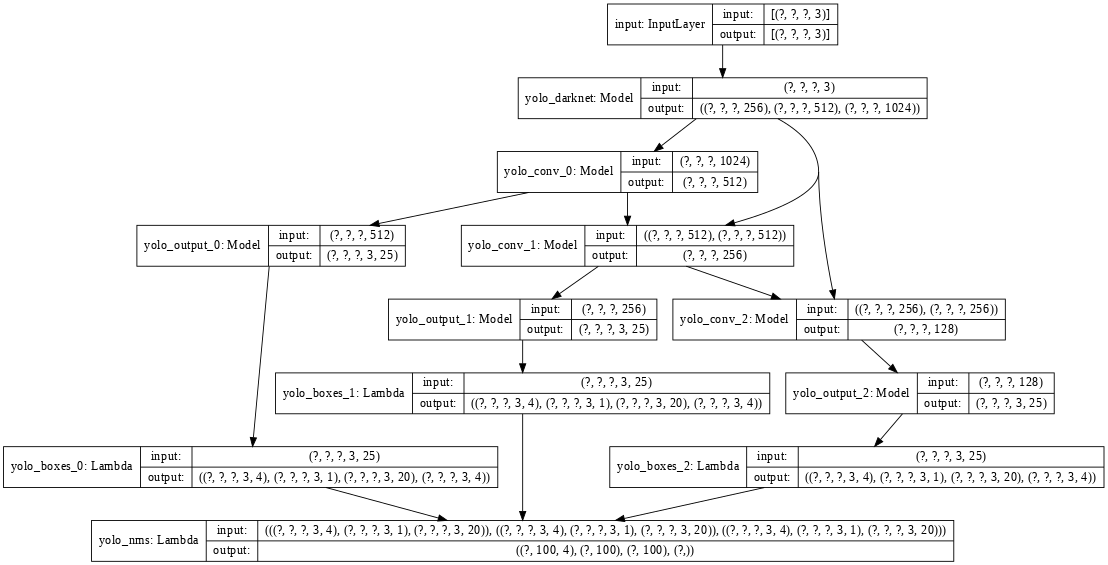

In [9]:
yolo.summary()
tf.keras.utils.plot_model(yolo, show_shapes=True, dpi=64)

In [0]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)